## Load the data & basic integrity checks

In [2]:
import pandas as pd

df = pd.read_csv('bns_processed.csv')

df.sample(5)

,Chapter,Chapter_name,Chapter_subtype,Section,Section_name,Description,Chapter_short,desc_len_chars,desc_len_words,has_crossref,Chapter_grouped
266,14,OF FALSE EVIDENCE AND OFFENCES AGAINST PUBLIC ...,OF FALSE EVIDENCE AND OFFENCES AGAINST PUBLIC ...,267,Intentional insult or interruption to public s...,"Whoever, intentionally offers any insult, or c...",FalseEvidence_PublicJustice,322,54,False,FalseEvidence_PublicJustice
64,5,OF OFFENCES AGAINST WOMAN AND CHILD,Of sexual offences,65,Punishment for rape in certain cases,"(1) Whoever, commits rape on a woman under six...",Offences_WomenChild,1060,179,False,Offences_WomenChild
89,5,OF OFFENCES AGAINST WOMAN AND CHILD,"Of causing miscarriage, etc",90,Death caused by act done with intent to cause ...,"1) Whoever, with intent to cause the miscarria...",Offences_WomenChild,578,100,False,Offences_WomenChild
139,6,OF OFFENCES AFFECTING THE HUMAN BODY,"Of kidnapping, abduction, slavery and forced l...",140,Kidnapping or abducting in order to murder or ...,(1) Whoever kidnaps or abducts any person in o...,Offences_HumanBody,1883,343,False,Offences_HumanBody
16,3,General exceptions,General exceptions,17,"Act done by a person justified, or by mistake ...",Nothing is an offence which is done by any per...,General_Exceptions,589,116,False,General_Exceptions


## Pre-processing text

In [3]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'section\s*\d+[a-zA-Z()]*', '', text)  # remove 'section xx'
    text = re.sub(r'\d+', '', text)  # remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)


[nltk_data] Downloading package stopwords to /home/vasant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vasant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/vasant/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
df['raw_text'] = df['Description']
df['clean_text'] = df['Description'].astype(str).apply(clean_text)

## Option 1: TF-IDF (Baseline & interpretable)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000,
    ngram_range=(1,2)  # include unigrams and bigrams
)

X_tfidf = tfidf.fit_transform(df['clean_text'])
X_tfidf.shape  # (358, 5000) e.g.

(358, 5000)

## Option 2: Sentence Embeddings (For semantic similarity / classification)

In [5]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')  # small and fast
X_embed = model.encode(df['Description'].tolist(), show_progress_bar=True)

/home/vasant/projects/Bhartiya-Nyay-Sanhita-LegalVerse/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.03it/s]


## Option 3: BERT Tokenization (for deep model inputs)

In [6]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokens = tokenizer(
    df['Description'].tolist(),
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

## Modeling (Baseline with TF-IDF + Logistic Regression)

### 1. Prepare Labels

In [16]:
df['Chapter_grouped'].unique()

array(['Other', 'Punishments', 'General_Exceptions',
       'Right_PrivateDefence', 'Abetment_Conspiracy_Attempt',
       'Offences_WomenChild', 'Offences_HumanBody', 'Offences_State',
       'Offences_ArmedForces', 'Offences_Elections', 'Offences_Currency',
       'Offences_PublicTranquillity', 'Offences_PublicServants',
       'Contempt_PublicServants', 'FalseEvidence_PublicJustice',
       'Offences_PublicHealthSafety', 'Offences_Religion',
       'Offences_Property', 'Offences_Documents_PropertyMarks',
       'Property_Marks', 'CriminalIntimidation_Defamation'], dtype=object)

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df['Chapter_grouped'])

# Split TF-IDF features and labels
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

### 2. Train a Logistic Regression Model

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

### 3. Evaluate

In [10]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Classification Report:
                                  precision    recall  f1-score   support

     Abetment_Conspiracy_Attempt       0.80      1.00      0.89         4
         Contempt_PublicServants       0.60      0.75      0.67         4
 CriminalIntimidation_Defamation       0.00      0.00      0.00         1
     FalseEvidence_PublicJustice       0.83      0.56      0.67         9
              General_Exceptions       0.57      1.00      0.73         4
            Offences_ArmedForces       1.00      0.50      0.67         2
               Offences_Currency       1.00      0.50      0.67         2
Offences_Documents_PropertyMarks       1.00      1.00      1.00         2
              Offences_Elections       1.00      1.00      1.00         2
              Offences_HumanBody       0.88      0.70      0.78        10
               Offences_Property       0.67      1.00      0.80         6
     Offences_PublicHealthSafety       1.00      0.83      0.91         6
         Offen

/home/pamya/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pamya/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pamya/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


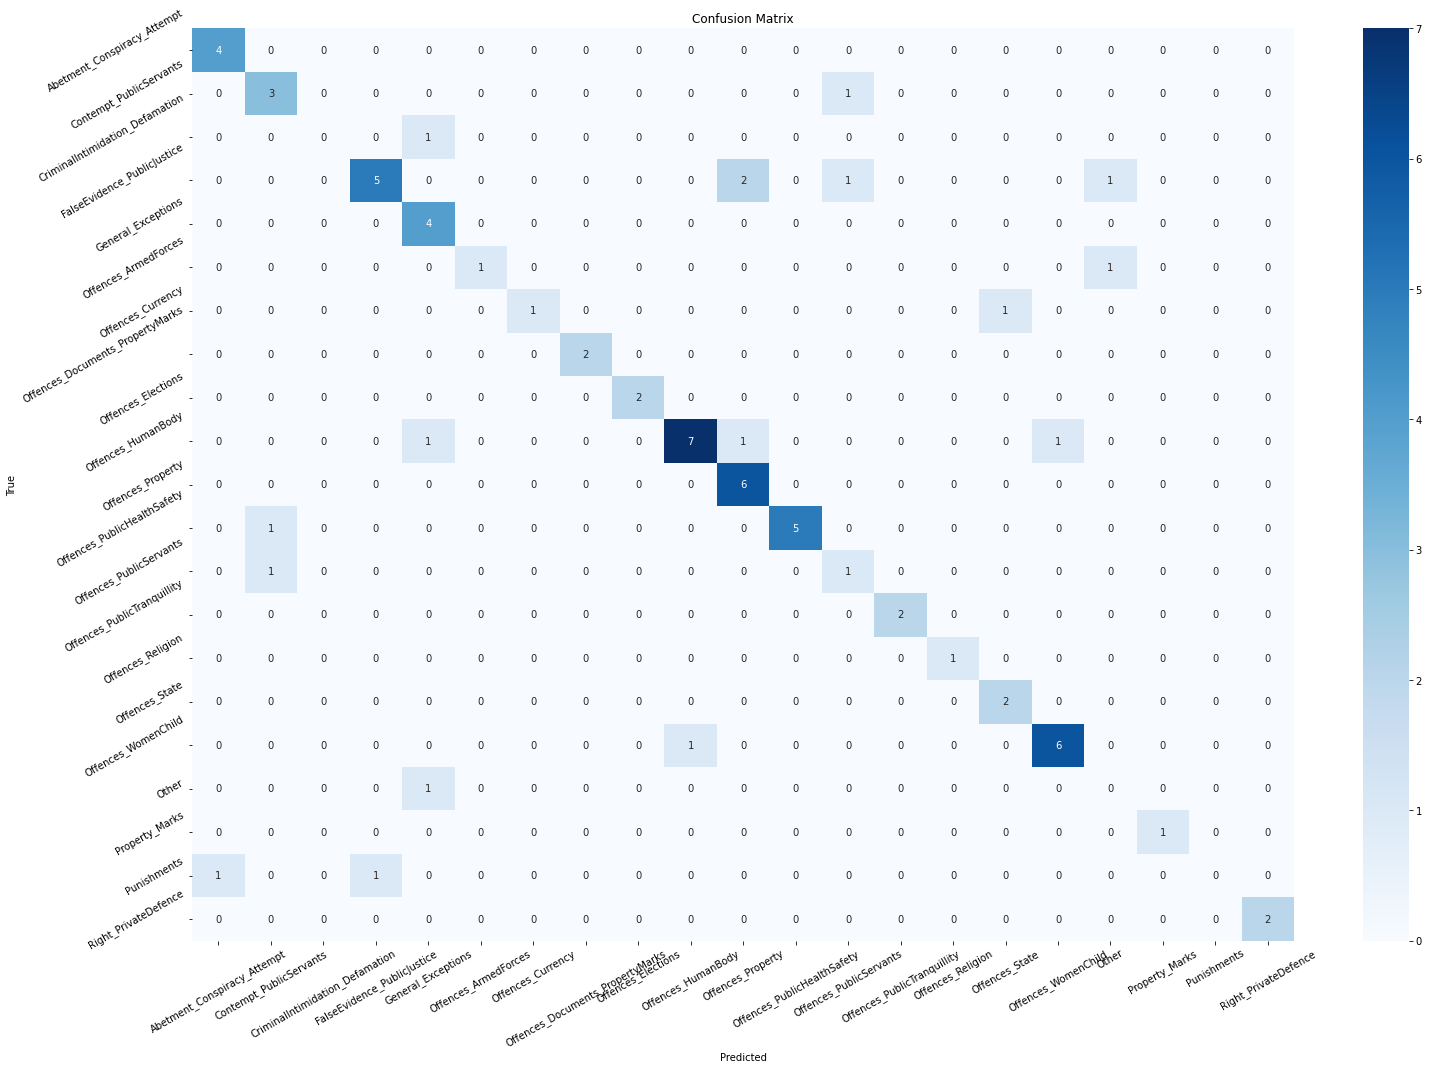

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(22, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=30)
plt.yticks(rotation=30)
plt.tight_layout()
plt.show()

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


# Models to test
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": LinearSVC(random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=200, random_state=42)
}

In [13]:
results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('clf', model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1_macro')
    results[name] = scores.mean()

# Show results
results_df = pd.DataFrame(results.items(), columns=['Model', 'Mean F1 Score'])
results_df.sort_values(by='Mean F1 Score', ascending=False)

/home/pamya/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/pamya/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/pamya/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/pamya/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/pamya/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of 

,Model,Mean F1 Score
1,SVM,0.673821
0,Random Forest,0.484345
3,Logistic Regression,0.335245
2,Naive Bayes,0.207054


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Define models
models = {
    "SVM": LinearSVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "Naive Bayes": MultinomialNB()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    macro_prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    macro_rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    macro_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    weighted_prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    weighted_rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    weighted_f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Macro Precision": macro_prec,
        "Macro Recall": macro_rec,
        "Macro F1": macro_f1,
        "Weighted Precision": weighted_prec,
        "Weighted Recall": weighted_rec,
        "Weighted F1": weighted_f1
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Sort by Macro F1 for easy ranking
results_df = results_df.sort_values(by="Macro F1", ascending=False).reset_index(drop=True)
results_df

/home/pamya/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


,Model,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted Precision,Weighted Recall,Weighted F1
0,SVM,0.833333,0.779946,0.770711,0.764664,0.801010,0.833333,0.808289
1,Random Forest,0.583333,0.553462,0.509221,0.504371,0.588090,0.583333,0.561992
2,Logistic Regression,0.583333,0.401661,0.379176,0.367260,0.522613,0.583333,0.517126
3,Naive Bayes,0.444444,0.208491,0.199887,0.174817,0.378458,0.444444,0.351432


### Experiment 1 — Cross-validation for all models

In [25]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.base import clone
import numpy as np
import pandas as pd

# Example classifiers (replace with yours)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Define models
models = {
    "SVM": SVC(probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB()
}

# Stratified KFold setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Results storage
results = []

for name, model in models.items():
    acc_scores, macro_prec, macro_rec, macro_f1, w_prec, w_rec, w_f1 = [], [], [], [], [], [], []
    
    for train_idx, val_idx in cv.split(X_tfidf, y):
        X_train, X_val = X_tfidf[train_idx], X_tfidf[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        clf = clone(model)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        
        acc_scores.append(accuracy_score(y_val, y_pred))
        macro_prec.append(precision_score(y_val, y_pred, average='macro', zero_division=0))
        macro_rec.append(recall_score(y_val, y_pred, average='macro', zero_division=0))
        macro_f1.append(f1_score(y_val, y_pred, average='macro', zero_division=0))
        w_prec.append(precision_score(y_val, y_pred, average='weighted', zero_division=0))
        w_rec.append(recall_score(y_val, y_pred, average='weighted', zero_division=0))
        w_f1.append(f1_score(y_val, y_pred, average='weighted', zero_division=0))
    
    results.append([
        name,
        np.mean(acc_scores),
        np.mean(macro_prec),
        np.mean(macro_rec),
        np.mean(macro_f1),
        np.mean(w_prec),
        np.mean(w_rec),
        np.mean(w_f1)
    ])

# Display results
df_results = pd.DataFrame(results, columns=[
    "Model", "Accuracy", "Macro Precision", "Macro Recall", "Macro F1",
    "Weighted Precision", "Weighted Recall", "Weighted F1"
])
df_results

,Model,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted Precision,Weighted Recall,Weighted F1
0,SVM,0.533451,0.424905,0.328190,0.340187,0.569042,0.533451,0.496738
1,Random Forest,0.625430,0.515534,0.506270,0.488375,0.582577,0.625430,0.579084
2,Logistic Regression,0.606064,0.442521,0.392203,0.388556,0.564063,0.606064,0.544261
3,Naive Bayes,0.474883,0.311627,0.254796,0.243970,0.463130,0.474883,0.400832


### Experiment 2 — Hyperparameter tuning for top models

In [26]:
from sklearn.model_selection import GridSearchCV

# 1. SVM tuning
svm_params = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_params, cv=5, scoring='f1_macro')
svm_grid.fit(X_train, y_train)
print("Best SVM params:", svm_grid.best_params_)
print("Best SVM score:", svm_grid.best_score_)

# 2. Random Forest tuning
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='f1_macro')
rf_grid.fit(X_train, y_train)
print("Best RF params:", rf_grid.best_params_)
print("Best RF score:", rf_grid.best_score_)

/home/vasant/projects/Bhartiya-Nyay-Sanhita-LegalVerse/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best SVM params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM score: 0.5150090692237308


/home/vasant/projects/Bhartiya-Nyay-Sanhita-LegalVerse/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best RF params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best RF score: 0.44710391363022933


### Experiment 3 — Ensemble Voting Classifier

In [27]:
from sklearn.ensemble import VotingClassifier

# Use best models from tuning
best_svm = svm_grid.best_estimator_
best_rf = rf_grid.best_estimator_

# Add Logistic Regression as tiebreaker
log_reg = LogisticRegression(max_iter=1000, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('svm', best_svm),
        ('rf', best_rf),
        ('lr', log_reg)
    ],
    voting='soft'
)

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

In [28]:
# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average='macro'))
print("Classification Report:")

print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

Accuracy: 0.9444444444444444
Macro F1: 0.9361250348092454
Classification Report:
                                  precision    recall  f1-score   support

     Abetment_Conspiracy_Attempt       0.80      1.00      0.89         4
         Contempt_PublicServants       1.00      1.00      1.00         4
 CriminalIntimidation_Defamation       1.00      1.00      1.00         1
     FalseEvidence_PublicJustice       0.90      1.00      0.95         9
              General_Exceptions       1.00      1.00      1.00         4
            Offences_ArmedForces       1.00      1.00      1.00         2
               Offences_Currency       1.00      0.50      0.67         2
Offences_Documents_PropertyMarks       1.00      0.50      0.67         2
              Offences_Elections       1.00      1.00      1.00         2
              Offences_HumanBody       1.00      0.90      0.95        10
               Offences_Property       1.00      1.00      1.00         6
     Offences_PublicHealthSafe

## Model Auditing for data leakage

### Where leakage / overfitting commonly comes from (specific to your pipeline)

- Vectorizer/feature fit on full dataset before split (TF-IDF or embeddings fit on all data → information from test leaks into train).

- Using X transformed outside the CV or split (e.g., building X_tfidf = tfidf.fit_transform(X) once, then splitting).

- Re-fitting tuned models on the entire dataset and then testing on a subset of that same dataset (instead of training only on train split).

- Not using Pipelines: separate transform + fit steps can accidentally fit transformers on test.

- Duplicates / near-duplicates in train and test (same exact section text or copied text across splits).

- Label leakage in text: descriptions containing the exact chapter name or section tag that trivially gives away the label.

- Improper cross-validation: using non-stratified CV with tiny classes or leaking parameters across folds.

- Using model probabilities from CV as features (stacking incorrectly) without out-of-fold predictions.

### Quick diagnostic checks

In [23]:
from sklearn.model_selection import train_test_split
X = df['Description']  # raw text column
y = df['Chapter_grouped']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Now these are Pandas Series of raw text — we can safely run:
train_texts = set(X_train.astype(str))
test_texts  = set(X_test.astype(str))

overlap = train_texts.intersection(test_texts)
print("Exact overlap between train and test:", len(overlap))
if overlap:
    print("Example overlapping text:", list(overlap)[:1])

Exact overlap between train and test: 0


In [25]:
from collections import Counter

# 3) Near-duplicate / very similar texts (quick hashing + length check)
def quick_hash(s):
    return hash(s.strip().lower()[:200])  # first 200 chars hash
train_hashes = Counter(quick_hash(t) for t in X_train)
test_hashes  = Counter(quick_hash(t) for t in X_test)
hash_overlap = sum((train_hashes & test_hashes).values())
print("Hash-overlap (possible near-duplicates):", hash_overlap)

# 4) Check if chapter name or section name appears verbatim in Description (label leakage)
def label_in_text(row):
    return (str(row['Chapter_name']).lower() in str(row['Description']).lower()) \
           or (str(row['Section_name']).lower() in str(row['Description']).lower())

df['label_in_text'] = df.apply(label_in_text, axis=1)
print("Rows where chapter/section name appears inside Description:", df['label_in_text'].sum())


Hash-overlap (possible near-duplicates): 1
Rows where chapter/section name appears inside Description: 29


### Safe re-run pipeline — no leakage, with stratified CV, pipelines, and ensemble

This code ensures every transformer is fitted only within CV folds or on the train split, and that tuned estimators are not trained on the test set.

Notes:
 - We use Pipeline so TF-IDF is fit only on training folds.
 - We do GridSearchCV with cv=StratifiedKFold to tune hyperparams safely.
 - We then build a VotingClassifier using the best estimators from GridSearch but fitted only on training data. The final evaluation is on the held-out test set created after all CV tuning (or you can report CV results instead of single test).

In [17]:
# SAFE PIPELINE + TUNING + ENSEMBLE (no leakage)
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# 1) split raw data first (ensure stratify)
X = df['Description'].values
y = df['Chapter_grouped'].values  # or Chapter_grouped

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [19]:
# 2) define pipelines (TF-IDF inside pipeline)
pipe_svm = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=10000)),
    ('svm', SVC(probability=True, random_state=42))
])

pipe_rf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=10000)),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_lr = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=10000)),
    ('lr', LogisticRegression(max_iter=2000, random_state=42))
])

# 3) Grid search (tune SVM and RF)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_param_grid = {
    'svm__kernel': ['linear'],   # linear performed best earlier
    'svm__C': [1, 5, 10]
}
rf_param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 20],
    'rf__min_samples_split': [2, 5]
}

svm_gs = GridSearchCV(pipe_svm, svm_param_grid, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)
rf_gs  = GridSearchCV(pipe_rf, rf_param_grid, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)

svm_gs.fit(X_train, y_train)
rf_gs.fit(X_train, y_train)

print("Best SVM params:", svm_gs.best_params_, "Best score:", svm_gs.best_score_)
print("Best RF params:", rf_gs.best_params_, "Best score:", rf_gs.best_score_)

# 4) Build VotingClassifier using pipelines' best estimators (these are fitted on X_train already)
best_svm_pipe = svm_gs.best_estimator_
best_rf_pipe  = rf_gs.best_estimator_
best_lr_pipe  = pipe_lr  # we can fit LR on X_train or also grid-search; for speed we fit default

best_lr_pipe.fit(X_train, y_train)

voting = VotingClassifier(
    estimators=[('svm', best_svm_pipe), ('rf', best_rf_pipe), ('lr', best_lr_pipe)],
    voting='soft',  # requires probability support
    n_jobs=-1
)

# Fit voting on TRAIN set only
voting.fit(X_train, y_train)

# Evaluate on TEST set (never seen during any fit/GS)
y_pred = voting.predict(X_test)

print("Final Test Accuracy:", accuracy_score(y_test, y_pred))
print("Final Test Macro F1:", f1_score(y_test, y_pred, average='macro'))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/home/vasant/projects/Bhartiya-Nyay-Sanhita-LegalVerse/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/vasant/projects/Bhartiya-Nyay-Sanhita-LegalVerse/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best SVM params: {'svm__C': 5, 'svm__kernel': 'linear'} Best score: 0.5999159888385895
Best RF params: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 100} Best score: 0.5035107143090336
Final Test Accuracy: 0.7361111111111112
Final Test Macro F1: 0.6235280017888714
Classification Report:
                                   precision    recall  f1-score   support

     Abetment_Conspiracy_Attempt       0.75      0.75      0.75         4
         Contempt_PublicServants       0.75      0.75      0.75         4
 CriminalIntimidation_Defamation       0.00      0.00      0.00         1
     FalseEvidence_PublicJustice       0.50      0.78      0.61         9
              General_Exceptions       0.80      1.00      0.89         4
            Offences_ArmedForces       0.00      0.00      0.00         2
               Offences_Currency       1.00      0.50      0.67         2
Offences_Documents_PropertyMarks       1.00      1.00      1.00         2
              Offe

In [8]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
import numpy as np

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(df['Chapter_grouped'])

# Load BERT model
bert_model = SentenceTransformer('all-MiniLM-L6-v2')  # Smaller, faster BERT

# Create embeddings
# X_embeddings = bert_model.encode(X, show_progress_bar=True)

# Define models
svm_clf = SVC(C=10, kernel='linear', probability=True, random_state=42)
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)

# Ensemble
ensemble = VotingClassifier(
    estimators=[
        ('svm', svm_clf),
        ('lr', lr_clf),
        ('rf', rf_clf)
    ],
    voting='soft'
)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_embed, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Train
ensemble.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import classification_report, accuracy_score
y_pred = ensemble.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.7083333333333334
                                  precision    recall  f1-score   support

     Abetment_Conspiracy_Attempt       0.75      0.75      0.75         4
         Contempt_PublicServants       0.40      0.50      0.44         4
 CriminalIntimidation_Defamation       0.00      0.00      0.00         1
     FalseEvidence_PublicJustice       0.54      0.78      0.64         9
              General_Exceptions       1.00      1.00      1.00         4
            Offences_ArmedForces       1.00      0.50      0.67         2
               Offences_Currency       1.00      1.00      1.00         2
Offences_Documents_PropertyMarks       1.00      1.00      1.00         2
              Offences_Elections       1.00      0.50      0.67         2
              Offences_HumanBody       0.53      0.80      0.64        10
               Offences_Property       0.71      0.83      0.77         6
     Offences_PublicHealthSafety       0.83      0.83      0.83         6
        

/home/vasant/projects/Bhartiya-Nyay-Sanhita-LegalVerse/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vasant/projects/Bhartiya-Nyay-Sanhita-LegalVerse/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vasant/projects/Bhartiya-Nyay-Sanhita-LegalVerse/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 

## Final model inference

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np


df = pd.read_csv('bns_processed.csv')
df.sample(3)

/home/vasant/projects/Bhartiya-Nyay-Sanhita-LegalVerse/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Chapter,Chapter_name,Chapter_subtype,Section,Section_name,Description,Chapter_short,desc_len_chars,desc_len_words,has_crossref,Chapter_grouped
46,4,"OF ABETMENT, CRIMINAL CONSPIRACY AND ATTEMPT",of abetment,47,Abetment in India of offences outside India.,A person abets an offence within the meaning o...,Abetment_Conspiracy_Attempt,328,57,False,Abetment_Conspiracy_Attempt
265,14,OF FALSE EVIDENCE AND OFFENCES AGAINST PUBLIC ...,OF FALSE EVIDENCE AND OFFENCES AGAINST PUBLIC ...,266,Violation of condition of remission of punishm...,"Whoever, having accepted any conditional remis...",FalseEvidence_PublicJustice,387,63,False,FalseEvidence_PublicJustice
249,14,OF FALSE EVIDENCE AND OFFENCES AGAINST PUBLIC ...,OF FALSE EVIDENCE AND OFFENCES AGAINST PUBLIC ...,250,"Taking gift, etc., to screen an offender from ...","Whoever accepts or attempts to obtain, or agre...",FalseEvidence_PublicJustice,1104,188,False,FalseEvidence_PublicJustice


In [2]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'section\s*\d+[a-zA-Z()]*', '', text)  # remove 'section xx'
    text = re.sub(r'\d+', '', text)  # remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /home/vasant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vasant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/vasant/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
df['raw_text'] = df['Description']
df['clean_text'] = df['Description'].astype(str).apply(clean_text)

In [15]:
X = df['clean_text'].values
y = df['Chapter_grouped']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split (common for both)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [16]:
# Define models
svm_clf = SVC(C=10, kernel='linear', probability=True, random_state=42)
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)

In [17]:
# ---------------------------
# PIPELINE A - TF-IDF
# ---------------------------
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

ensemble_tfidf = VotingClassifier(
    estimators=[('svm', svm_clf), ('lr', lr_clf), ('rf', rf_clf)],
    voting='soft'
)
ensemble_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = ensemble_tfidf.predict(X_test_tfidf)

In [18]:
# ---------------------------
# PIPELINE B - BERT
# ---------------------------
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
X_train_bert = bert_model.encode(X_train_text, show_progress_bar=True)
X_test_bert = bert_model.encode(X_test_text, show_progress_bar=True)

ensemble_bert = VotingClassifier(
    estimators=[('svm', svm_clf), ('lr', lr_clf), ('rf', rf_clf)],
    voting='soft'
)
ensemble_bert.fit(X_train_bert, y_train)
y_pred_bert = ensemble_bert.predict(X_test_bert)

Batches: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.88it/s]


In [16]:
# ---------------------------
# METRICS COMPARISON
# ---------------------------
def get_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    return [acc, macro_p, macro_r, macro_f, weighted_p, weighted_r, weighted_f]

In [19]:
results = pd.DataFrame(
    [
        ['TF-IDF'] + get_metrics(y_test, y_pred_tfidf),
        ['BERT'] + get_metrics(y_test, y_pred_bert)
    ],
    columns=['Model', 'Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1',
             'Weighted Precision', 'Weighted Recall', 'Weighted F1']
)

In [20]:
print("\n=== Model Performance Comparison ===\n")
print(results)

# Optionally: detailed classification reports
print("\n--- TF-IDF Classification Report ---")
print(classification_report(y_test, y_pred_tfidf, target_names=le.classes_, zero_division=0))

print("\n--- BERT Classification Report ---")
print(classification_report(y_test, y_pred_bert, target_names=le.classes_, zero_division=0))


=== Model Performance Comparison ===

    Model  Accuracy  Macro Precision  Macro Recall  Macro F1  \
0  TF-IDF  0.736111         0.659123      0.605367  0.611656   
1    BERT  0.763889         0.624490      0.633938  0.620898   

   Weighted Precision  Weighted Recall  Weighted F1  
0            0.698731         0.736111     0.699010  
1            0.705820         0.763889     0.723299  

--- TF-IDF Classification Report ---
                                  precision    recall  f1-score   support

     Abetment_Conspiracy_Attempt       1.00      1.00      1.00         4
         Contempt_PublicServants       0.67      0.50      0.57         4
 CriminalIntimidation_Defamation       0.00      0.00      0.00         1
     FalseEvidence_PublicJustice       0.57      0.89      0.70         9
              General_Exceptions       0.67      1.00      0.80         4
            Offences_ArmedForces       0.00      0.00      0.00         2
               Offences_Currency       1.00      

## Using model trained thorugh cv

In [4]:
X = df['clean_text'].values
y = df['Chapter_grouped']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split (common for both)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

### TF-IDF hyper parameter tuning

In [5]:
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=5000,
    ngram_range=(1,2)  # include unigrams and bigrams
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

In [6]:
from sklearn.model_selection import GridSearchCV

# 1. SVM tuning
svm_params = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_params, cv=5, scoring='f1_macro')
svm_grid.fit(X_train_tfidf, y_train)
print("Best SVM params:", svm_grid.best_params_)
print("Best SVM score:", svm_grid.best_score_)

# 2. Random Forest tuning
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='f1_macro')
rf_grid.fit(X_train_tfidf, y_train)
print("Best RF params:", rf_grid.best_params_)
print("Best RF score:", rf_grid.best_score_)

/home/vasant/projects/Bhartiya-Nyay-Sanhita-LegalVerse/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best SVM params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM score: 0.5773390222580029


/home/vasant/projects/Bhartiya-Nyay-Sanhita-LegalVerse/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best RF params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best RF score: 0.48792703440105034


In [10]:
# Use best models from tuning
best_svm = svm_grid.best_estimator_
best_rf = rf_grid.best_estimator_

# Add Logistic Regression as tiebreaker
log_reg = LogisticRegression(max_iter=1000, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('svm', best_svm),
        ('rf', best_rf),
        ('lr', log_reg)
    ],
    voting='soft'
)

voting_clf.fit(X_train_tfidf, y_train)
y_pred_tfidf = voting_clf.predict(X_test_tfidf)

## BERT Hyper Parameter tuning

In [12]:
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
X_train_bert = bert_model.encode(X_train_text, show_progress_bar=True)
X_test_bert = bert_model.encode(X_test_text, show_progress_bar=True)

Batches: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.97it/s]


In [13]:
from sklearn.model_selection import GridSearchCV

# 1. SVM tuning
svm_params = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_params, cv=5, scoring='f1_macro')
svm_grid.fit(X_train_bert, y_train)
print("Best SVM params:", svm_grid.best_params_)
print("Best SVM score:", svm_grid.best_score_)

# 2. Random Forest tuning
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='f1_macro')
rf_grid.fit(X_train_bert, y_train)
print("Best RF params:", rf_grid.best_params_)
print("Best RF score:", rf_grid.best_score_)

/home/vasant/projects/Bhartiya-Nyay-Sanhita-LegalVerse/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best SVM params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM score: 0.6503978658039914


/home/vasant/projects/Bhartiya-Nyay-Sanhita-LegalVerse/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best RF params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best RF score: 0.4197974397442216


In [14]:
# Use best models from tuning
best_svm = svm_grid.best_estimator_
best_rf = rf_grid.best_estimator_

# Add Logistic Regression as tiebreaker
log_reg = LogisticRegression(max_iter=1000, random_state=42)

voting_clf_bert = VotingClassifier(
    estimators=[
        ('svm', best_svm),
        ('rf', best_rf),
        ('lr', log_reg)
    ],
    voting='soft'
)

voting_clf_bert.fit(X_train_bert, y_train)
y_pred_bert = voting_clf_bert.predict(X_test_bert)

In [17]:
results = pd.DataFrame(
    [
        ['TF-IDF'] + get_metrics(y_test, y_pred_tfidf),
        ['BERT'] + get_metrics(y_test, y_pred_bert)
    ],
    columns=['Model', 'Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1',
             'Weighted Precision', 'Weighted Recall', 'Weighted F1']
)

In [18]:
print("\n=== Model Performance Comparison ===\n")
print(results)

# Optionally: detailed classification reports
print("\n--- TF-IDF Classification Report ---")
print(classification_report(y_test, y_pred_tfidf, target_names=le.classes_, zero_division=0))

print("\n--- BERT Classification Report ---")
print(classification_report(y_test, y_pred_bert, target_names=le.classes_, zero_division=0))


=== Model Performance Comparison ===

    Model  Accuracy  Macro Precision  Macro Recall  Macro F1  \
0  TF-IDF      0.75         0.758333      0.671504  0.689549   
1    BERT      0.75         0.618285      0.628647  0.616239   

   Weighted Precision  Weighted Recall  Weighted F1  
0            0.762731             0.75     0.736604  
1            0.694096             0.75     0.713317  

--- TF-IDF Classification Report ---
                                  precision    recall  f1-score   support

     Abetment_Conspiracy_Attempt       1.00      0.75      0.86         4
         Contempt_PublicServants       0.50      0.75      0.60         4
 CriminalIntimidation_Defamation       0.00      0.00      0.00         1
     FalseEvidence_PublicJustice       0.58      0.78      0.67         9
              General_Exceptions       0.67      1.00      0.80         4
            Offences_ArmedForces       1.00      0.50      0.67         2
               Offences_Currency       1.00      

In [ ]:
# file: train_bns_ensemble.py
import os
import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
)

# -----------------------
# Config
# -----------------------
RANDOM_STATE = 42
TEST_SIZE = 0.20
MIN_SAMPLES_TO_KEEP = 2  # classes with < this will be grouped into "Other"
ARTIFACT_DIR = "artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# -----------------------
# Load data (replace with actual file)
# -----------------------
# df must contain at least: 'Description' (text) and 'Chapter_name' (label)
# Example:
# df = pd.read_csv("bns_sections.csv")
# For demo, assume df is already loaded
# -----------------------
# Uncomment and update above line to load your data
# df = pd.read_csv("bns_sections.csv")

# For safety check: ensure columns exist
# assert 'Description' in df.columns and 'Chapter_name' in df.columns

# -----------------------
# Preprocess labels: merge rare classes into "Other"
# -----------------------
def merge_rare_labels(df, label_col='Chapter_name', min_samples=MIN_SAMPLES_TO_KEEP):
    counts = df[label_col].value_counts()
    rare = counts[counts < min_samples].index.tolist()
    df = df.copy()
    if rare:
        df[label_col] = df[label_col].apply(lambda v: v if v not in rare else "Other")
    return df, rare

# -----------------------
# Build pipeline (single TF-IDF followed by Voting classifier)
# -----------------------
def build_pipeline(tfidf_max_features=5000):
    # classifiers must support predict_proba for soft voting; SVC(probability=True) is slower but OK.
    svm_clf = SVC(C=10, kernel='linear', probability=True, random_state=RANDOM_STATE)
    lr_clf = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE)
    rf_clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE)

    voting = VotingClassifier(
        estimators=[
            ('svm', svm_clf),
            ('lr', lr_clf),
            ('rf', rf_clf)
        ],
        voting='soft',  # uses predict_proba
        n_jobs=-1
    )

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=tfidf_max_features)),
        ('voting', voting)
    ])
    return pipeline

# -----------------------
# Train, evaluate, and save
# -----------------------
def train_and_save(df, text_col='Description', label_col='Chapter_name'):
    # Merge rare labels
    df2, rare = merge_rare_labels(df, label_col=label_col, min_samples=MIN_SAMPLES_TO_KEEP)
    print(f"Merged {len(rare)} rare classes into 'Other': {rare}")

    X = df2[text_col].astype(str).values
    y = df2[label_col].astype(str).values

    # Encode labels
    le = LabelEncoder()
    y_enc = le.fit_transform(y)

    # Split (stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_enc, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_enc
    )
    print("Train/test sizes:", len(X_train), len(X_test))

    # Build pipeline
    pipeline = build_pipeline(tfidf_max_features=5000)

    # Cross-validate on training set for robust estimate
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scoring = 'f1_macro'
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    print(f"CV ({scoring}) on train: mean={cv_scores.mean():.4f}, std={cv_scores.std():.4f}")

    # Fit on full training set
    pipeline.fit(X_train, y_train)

    # Evaluate on test set
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)

    print("\n=== Test set evaluation ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro Precision: {macro_p:.4f}, Macro Recall: {macro_r:.4f}, Macro F1: {macro_f:.4f}")
    print(f"Weighted Precision: {weighted_p:.4f}, Weighted Recall: {weighted_r:.4f}, Weighted F1: {weighted_f:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

    # Save artifacts
    pipeline_path = os.path.join(ARTIFACT_DIR, "bns_pipeline_v1.joblib")
    le_path = os.path.join(ARTIFACT_DIR, "label_encoder_v1.joblib")
    joblib.dump(pipeline, pipeline_path)
    joblib.dump(le, le_path)
    print(f"\nSaved pipeline to: {pipeline_path}")
    print(f"Saved label encoder to: {le_path}")

    # Save a short report CSV with key metrics
    report = {
        "pipeline": pipeline_path,
        "label_encoder": le_path,
        "cv_f1_macro_mean": cv_scores.mean(),
        "cv_f1_macro_std": cv_scores.std(),
        "test_accuracy": acc,
        "test_macro_f1": macro_f,
        "test_weighted_f1": weighted_f
    }
    pd.DataFrame([report]).to_csv(os.path.join(ARTIFACT_DIR, "training_report_v1.csv"), index=False)
    print("Saved training report.")

    return pipeline_path, le_path, le.classes_

# -----------------------
# Inference helper
# -----------------------
def predict_texts(texts, pipeline_path=os.path.join(ARTIFACT_DIR, "bns_pipeline_v1.joblib"),
                  le_path=os.path.join(ARTIFACT_DIR, "label_encoder_v1.joblib")):
    """
    texts: list of raw description strings
    returns: DataFrame with predicted label and probability
    """
    pipeline = joblib.load(pipeline_path)
    le = joblib.load(le_path)
    probs = pipeline.predict_proba(texts)
    preds_idx = np.argmax(probs, axis=1)
    preds = le.inverse_transform(preds_idx)
    max_probs = probs.max(axis=1)
    return pd.DataFrame({"text": texts, "pred_label": preds, "prob": max_probs})

# -----------------------
# Example run (uncomment to run)
# -----------------------
# if __name__ == "__main__":
#     df = pd.read_csv("bns_sections.csv")  # <-- update with your filename
#     train_and_save(df, text_col='Description', label_col='Chapter_short')  # or 'Chapter_grouped'
#     # After training, inference example:
#     # print(predict_texts(["A short legal provision text ..."]))
